In [1]:
from adspredictor.trainer.trainer import *
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('comparison_rough-fine_filtered.pkl')
df = df.loc[:, ['np', 'adsconf', 'atoms_fine']]
df

,np,adsconf,atoms_fine
0,MS,Ag_09,"(Atom('Cu', [np.float64(12.29521), np.float64(..."
1,MS,Ag_07,"(Atom('Cu', [np.float64(12.31017), np.float64(..."
2,MS,Ag_01,"(Atom('Cu', [np.float64(12.31917), np.float64(..."
3,MS,Ag_06,"(Atom('Cu', [np.float64(12.28306), np.float64(..."
4,MS,Ag_08,"(Atom('Cu', [np.float64(12.27612), np.float64(..."
...,...,...,...
322,34152,Cu_03,"(Atom('Cu', [np.float64(12.28599), np.float64(..."
324,34152,Pd_01,"(Atom('Cu', [np.float64(12.29058), np.float64(..."
325,34152,Au_02,"(Atom('Cu', [np.float64(12.28171), np.float64(..."
326,34152,Pd_06,"(Atom('Cu', [np.float64(12.29228), np.float64(..."


In [3]:
ref = {'AS': -171.092, 'LS': -170.383, 'MS': -172.001, 
       '23154': -171.081, '31245': -171.070, '34152': -171.076, '43125': -171.113,
       'LSminus1': -170.513}
CO_g = -14.424

# rename column atoms_fine to Atoms
df = df.rename(columns={'atoms_fine': 'Atoms'})

# Extract energy from atoms object
df['energy'] = df.Atoms.apply(lambda x: x.get_potential_energy())

# Calculate the adsorption energy
df['AdsE'] = df.apply(lambda x: x.energy - ref[x.np] - CO_g, axis=1)
df

,np,adsconf,Atoms,energy,AdsE
0,MS,Ag_09,"(Atom('Cu', [np.float64(12.29521), np.float64(...",-186.709519,-0.284519
1,MS,Ag_07,"(Atom('Cu', [np.float64(12.31017), np.float64(...",-186.632544,-0.207544
2,MS,Ag_01,"(Atom('Cu', [np.float64(12.31917), np.float64(...",-186.926266,-0.501266
3,MS,Ag_06,"(Atom('Cu', [np.float64(12.28306), np.float64(...",-186.684826,-0.259826
4,MS,Ag_08,"(Atom('Cu', [np.float64(12.27612), np.float64(...",-186.620595,-0.195595
...,...,...,...,...,...
322,34152,Cu_03,"(Atom('Cu', [np.float64(12.28599), np.float64(...",-186.393247,-0.893247
324,34152,Pd_01,"(Atom('Cu', [np.float64(12.29058), np.float64(...",-186.909588,-1.409588
325,34152,Au_02,"(Atom('Cu', [np.float64(12.28171), np.float64(...",-186.546506,-1.046506
326,34152,Pd_06,"(Atom('Cu', [np.float64(12.29228), np.float64(...",-186.816142,-1.316142


In [4]:
from adspredictor.featurizer.featurizer import FeatureCreator

fc = FeatureCreator(df, ads=55, listmetals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'])
cutoffs = [2.5, 4.62672286, 5.22347908, 6.33086662]    # Optimized cutoffs w/ 5th cutoff, the 5th was the same as the 4th

df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)
df.sample(5)

,np,adsconf,Atoms,energy,AdsE,R0_Ag,R0_Au,R0_Cu,R0_Pd,R0_Pt,...,R2_Ag,R2_Au,R2_Cu,R2_Pd,R2_Pt,R3_Ag,R3_Au,R3_Cu,R3_Pd,R3_Pt
87,31245,Pt_01,"(Atom('Cu', [np.float64(12.31101), np.float64(...",-187.483637,-1.989637,0,0,0,0,1,...,0,0,0,0,0,1,0,3,4,1
301,34152,Cu_06,"(Atom('Cu', [np.float64(12.29749), np.float64(...",-186.400623,-0.900623,0,0,1,0,0,...,0,0,0,0,0,3,2,0,0,2
142,43125,Au_06,"(Atom('Pd', [np.float64(12.23919), np.float64(...",-186.338017,-0.801017,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
133,43125,Au_07,"(Atom('Pd', [np.float64(12.21645), np.float64(...",-186.063871,-0.526871,0,1,0,0,0,...,0,0,0,0,0,1,1,0,3,2
228,AS,Ag_04,"(Atom('Pt', [np.float64(12.27788), np.float64(...",-185.943338,-0.427338,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [5]:
from sklearn.svm import SVR
from adspredictor.trainer.trainer import Trainer

features_to_use = []
for col in df.columns:
    if 'R' in col and '_' in col or 'AdsE' in col:
        features_to_use.append(col)

df_to_train = df.loc[:, features_to_use].copy()

# Initialize the trainer with the SVR model
trainer = Trainer(
    dataframe=df_to_train,
    target_column='AdsE',
    model=SVR,
    test_size=0.2,
    random_state=42,
    kernel='rbf',  # Additional model parameters
    C=1.0
    )

# Split the data and train the model
trainer.split_data()
trainer.train()

In [11]:
from prettytable import PrettyTable

# Evaluate the model
metrics = trainer.evaluate()
# Print the evaluation metrics in a nice table format

table = PrettyTable()
table.field_names = ["Metric", "Value"]

for key, value in metrics.items():
    if key == 'R2':
        table.add_row([key, f"{value:5.4f}"])
    else:
        table.add_row([key, f"{value:5.2f}"])

print(table)

+--------+--------+
| Metric | Value  |
+--------+--------+
|  MAE   |  0.17  |
|  RMSE  |  0.23  |
|   R2   | 0.8632 |
+--------+--------+


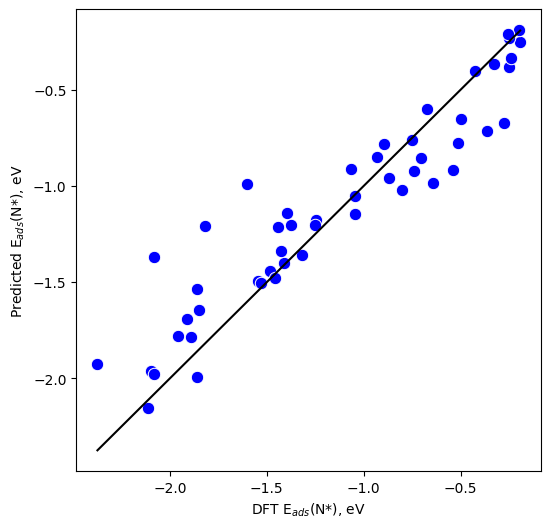

In [22]:
## Plot the parity plot

import matplotlib.pyplot as plt
import seaborn as sns

y_pred = trainer.model.predict(trainer.X_test)

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the parity plot
sns.scatterplot(x=trainer.y_test, y=y_pred, ax=ax, s=80, color='blue')
sns.lineplot(x=trainer.y_test, y=trainer.y_test, ax=ax, color='black')

# Set the labels
ax.set_xlabel(r'DFT E$_{ads}$(N*), eV')
ax.set_ylabel(r'Predicted E$_{ads}$(N*), eV')

plt.show()
